<a href="https://colab.research.google.com/github/lenust/leaf_damage_neuronet/blob/main/dataset_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Вырезание изображение листьев со скана:

In [ ]:
import os
import cv2
import numpy as np

# Путь к папке с изображениями
image_folder = '/content/drive/MyDrive/нейросеть/leaves'

# Создание папки для сохранения выделенных объектов
output_folder = '/content/drive/MyDrive/нейросеть/leaves_without'
os.makedirs(output_folder, exist_ok=True)

# Параметры алгоритма сегментации
threshold_value = 12
min_area_threshold = 1000

# Перебор изображений в папке
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(image_folder, filename)
        # Загрузка изображения
        image = cv2.imread(image_path)

        # Конвертируем изображение в оттенки серого и применяем бинаризацию
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Ищем контуры объектов на изображении
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        min_area = 50000  # Минимальная площадь для сохранения контура
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

        # Выделение объектов и сохранение на отдельных изображениях
        for i, contour in enumerate(filtered_contours):
            # Создание пустого изображения с белым фоном размером маски
            x, y, w, h = cv2.boundingRect(contour)
            object_image = np.ones((h, w, 3), dtype=np.uint8) * 255

            # Создание маски контура
            mask = np.zeros((h, w), dtype=np.uint8)
            contour_offset = contour - np.array([[x, y]])
            cv2.drawContours(mask, [contour_offset], -1, (255), thickness=cv2.FILLED)

            # Применение маски на изображение
            object_pixels = cv2.bitwise_and(image[y:y+h, x:x+w], image[y:y+h, x:x+w], mask=mask)

            # Копирование объекта на пустое изображение с белым фоном
            object_image[mask == 255] = object_pixels[mask == 255]

            # Сохранение изображения с объектом на белом фоне
            object_filename = f'{filename}_object_{i}.jpg'
            object_filepath = os.path.join(output_folder, object_filename)
            cv2.imwrite(object_filepath, object_image)

Увеличение размера датасета за счет поворотов:

In [ ]:
from PIL import Image, ImageDraw
import os

# путь к папке с изображениями
image_folder = "/content/drive/MyDrive/нейросеть/leaves_without"

# проходимся по каждому файлу в папке
for filename in os.listdir(image_folder):
    # проверяем, является ли файл изображением
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # открываем изображение
        image = Image.open(os.path.join(image_folder, filename))

        # поворачиваем изображение на 90 градусов
        rotated_image = image.rotate(90, expand = True)
        # сохраняем повернутое изображение в ту же папку
        rotated_image.save(os.path.join(image_folder, f"{filename.split('.')[0]}_rotated_90.jpg"))

        # поворачиваем изображение на 180 градусов
        rotated_image = image.rotate(180, expand = True)
        # сохраняем повернутое изображение в ту же папку
        rotated_image.save(os.path.join(image_folder, f"{filename.split('.')[0]}_rotated_180.jpg"))

        # поворачиваем изображение на 270 градусов
        rotated_image = image.rotate(270, expand = True)
        # сохраняем повернутое изображение в ту же папку
        rotated_image.save(os.path.join(image_folder, f"{filename.split('.')[0]}_rotated_270.jpg"))

Создание искусственных погрызов на изображении:

In [ ]:
from PIL import Image, ImageDraw
import os
import random

def add_random_circles_to_image(image):
    # Создаем объект для рисования на изображении
    draw = ImageDraw.Draw(image)

    num_groups = random.randint(2, 3)
    for i in range(num_groups):
        # Выбираем случайную точку на изображении
        x = random.randint(0, image.width)
        y = random.randint(0, image.height)

        # Выбираем случайный радиус для этой группы кругов
        radius = random.randint(10, 60)

        # Генерируем несколько кругов в пределах этого радиуса
        num_circles = random.randint(3, 6)
        for j in range(num_circles):
          point_x = random.randint(x-radius, x+radius)
          point_y = random.randint(y-radius, y+radius)
          # Выбираем случайный радиус для каждого круга в группе
          circle_radius = random.randint(5, int(radius*2/3))

          # Рисуем круг
          draw.ellipse((point_x-circle_radius, point_y-circle_radius, point_x+circle_radius, point_y+circle_radius), fill=(255, 255, 255))

    return image

def add_random_circles_to_folder(input_folder, output_folder):
    # Создаем выходную папку, если она не существует
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Обходим все файлы во входной папке
    for filename in os.listdir(input_folder):
        # Игнорируем файлы, которые не являются изображениями
        if not filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue

        # Открываем изображение
        with Image.open(os.path.join(input_folder, filename)) as image:
            # Добавляем случайные круги на изображение
            image_with_circles = add_random_circles_to_image(image)

            # Сохраняем измененное изображение в выходную папку
            new_filename = os.path.join(output_folder, filename)
            image_with_circles.save(new_filename)

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/нейросеть/leaves_without'
    output_folder = '/content/drive/MyDrive/нейросеть/leaves_with/with_medium'
    add_random_circles_to_folder(input_folder, output_folder)

In [ ]:
from PIL import Image, ImageDraw
import os
import random

def add_random_circles_to_image(image):
    # Создаем объект для рисования на изображении
    draw = ImageDraw.Draw(image)

    num_groups = random.randint(2, 3)
    for i in range(num_groups):
        # Выбираем случайную точку на изображении
        x = random.randint(0, image.width)
        y = random.randint(0, image.height)

        # Выбираем случайный радиус для этой группы кругов
        radius = random.randint(10, 20)

        # Генерируем несколько кругов в пределах этого радиуса
        num_circles = random.randint(2, 5)
        for j in range(num_circles):
          point_x = random.randint(x-radius, x+radius)
          point_y = random.randint(y-radius, y+radius)
          # Выбираем случайный радиус для каждого круга в группе
          circle_radius = random.randint(2, int(radius*3/4))

          # Рисуем круг
          draw.ellipse((point_x-circle_radius, point_y-circle_radius, point_x+circle_radius, point_y+circle_radius), fill=(255, 255, 255))

    return image

def add_random_circles_to_folder(input_folder, output_folder):
    # Создаем выходную папку, если она не существует
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Обходим все файлы во входной папке
    for filename in os.listdir(input_folder):
        # Игнорируем файлы, которые не являются изображениями
        if not filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue

        # Открываем изображение
        with Image.open(os.path.join(input_folder, filename)) as image:
            # Добавляем случайные круги на изображение
            image_with_circles = add_random_circles_to_image(image)

            # Сохраняем измененное изображение в выходную папку
            new_filename = os.path.join(output_folder, filename)
            image_with_circles.save(new_filename)

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/нейросеть/leaves_without'
    output_folder = '/content/drive/MyDrive/нейросеть/leaves_with/with_small'
    add_random_circles_to_folder(input_folder, output_folder)

In [ ]:
from PIL import Image, ImageDraw
import os
import random

def add_random_circles_to_image(image):
    # Создаем объект для рисования на изображении
    draw = ImageDraw.Draw(image)

    num_groups = random.randint(3, 6)
    for i in range(num_groups):
        # Выбираем случайную точку на изображении
        x = random.randint(0, image.width)
        y = random.randint(0, image.height)

        # Выбираем случайный радиус для этой группы кругов
        radius = random.randint(10, 70)

        # Генерируем несколько кругов в пределах этого радиуса
        num_circles = random.randint(4, 8)
        for j in range(num_circles):
          point_x = random.randint(x-radius, x+radius)
          point_y = random.randint(y-radius, y+radius)
          # Выбираем случайный радиус для каждого круга в группе
          circle_radius = random.randint(5, int(radius*2/3))

          # Рисуем круг
          draw.ellipse((point_x-circle_radius, point_y-circle_radius, point_x+circle_radius, point_y+circle_radius), fill=(255, 255, 255))

    return image

def add_random_circles_to_folder(input_folder, output_folder):
    # Создаем выходную папку, если она не существует
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Обходим все файлы во входной папке
    for filename in os.listdir(input_folder):
        # Игнорируем файлы, которые не являются изображениями
        if not filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue

        # Открываем изображение
        with Image.open(os.path.join(input_folder, filename)) as image:
            # Добавляем случайные круги на изображение
            image_with_circles = add_random_circles_to_image(image)

            # Сохраняем измененное изображение в выходную папку
            new_filename = os.path.join(output_folder, filename)
            image_with_circles.save(new_filename)

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/нейросеть/leaves_without'
    output_folder = '/content/drive/MyDrive/нейросеть/leaves_with/with_big'
    add_random_circles_to_folder(input_folder, output_folder)

In [ ]:
from PIL import Image, ImageDraw
import os
import random
import math

def add_random_circles_to_image(image):
    # Создаем объект для рисования на изображении
    draw = ImageDraw.Draw(image)

    num_groups = random.randint(1, 3)
    for i in range(num_groups):
        # Выбираем случайную точку на изображении
        x = random.randint(0, image.width)
        y = random.randint(0, image.height)

        # Выбираем случайный радиус для этой группы кругов
        radius = random.randint(1, 10)
        draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill=(255, 255, 255))

        # Генерируем несколько кругов в пределах этого радиуса
        num_circles = random.randint(1, 10)
        for i in range(num_circles):
          # Выбираем случайный угол для точки
          angle = random.uniform(0, 2*math.pi)
          # Вычисляем координаты точки на радиусе
          point_x = x + int(radius * math.cos(angle))
          point_y = y + int(radius * math.sin(angle))
          # Выбираем случайный радиус для круга
          circle_radius = random.randint(1, 10)

          # Рисуем круг
          draw.ellipse((point_x-circle_radius, point_y-circle_radius, point_x+circle_radius, point_y+circle_radius), fill=(255, 255, 255))

    return image

def add_random_circles_to_folder(input_folder, output_folder):
    # Создаем выходную папку, если она не существует
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Обходим все файлы во входной папке
    for filename in os.listdir(input_folder):
        # Игнорируем файлы, которые не являются изображениями
        if not filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue

        # Открываем изображение
        with Image.open(os.path.join(input_folder, filename)) as image:
            # Добавляем случайные круги на изображение
            image_with_circles = add_random_circles_to_image(image)

            # Сохраняем измененное изображение в выходную папку
            new_filename = os.path.join(output_folder, filename)
            image_with_circles.save(new_filename)

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/нейросеть/leaves_without'
    output_folder = '/content/drive/MyDrive/нейросеть/leaves_with/with_small2'
    add_random_circles_to_folder(input_folder, output_folder)

In [ ]:
from PIL import Image, ImageDraw
import os
import random
import math

def add_random_circles_to_image(image):
    # Создаем объект для рисования на изображении
    draw = ImageDraw.Draw(image)

    num_groups = random.randint(2, 4)
    for i in range(num_groups):
        # Выбираем случайную точку на изображении
        x = random.randint(0, image.width)
        y = random.randint(0, image.height)

        # Выбираем случайный радиус для этой группы кругов
        radius = random.randint(3, 15)
        draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill=(255, 255, 255))

        # Генерируем несколько кругов в пределах этого радиуса
        num_circles = random.randint(3, 12)
        for i in range(num_circles):
          # Выбираем случайный угол для точки
          angle = random.uniform(0, 2*math.pi)
          # Вычисляем координаты точки на радиусе
          point_x = x + int(radius * math.cos(angle))
          point_y = y + int(radius * math.sin(angle))
          # Выбираем случайный радиус для круга
          circle_radius = random.randint(3, 15)

          # Рисуем круг
          draw.ellipse((point_x-circle_radius, point_y-circle_radius, point_x+circle_radius, point_y+circle_radius), fill=(255, 255, 255))

    return image

def add_random_circles_to_folder(input_folder, output_folder):
    # Создаем выходную папку, если она не существует
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Обходим все файлы во входной папке
    for filename in os.listdir(input_folder):
        # Игнорируем файлы, которые не являются изображениями
        if not filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue

        # Открываем изображение
        with Image.open(os.path.join(input_folder, filename)) as image:
            # Добавляем случайные круги на изображение
            image_with_circles = add_random_circles_to_image(image)

            # Сохраняем измененное изображение в выходную папку
            new_filename = os.path.join(output_folder, filename)
            image_with_circles.save(new_filename)

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/нейросеть/leaves_without'
    output_folder = '/content/drive/MyDrive/нейросеть/leaves_with/with_medium2'
    add_random_circles_to_folder(input_folder, output_folder)

In [ ]:
from PIL import Image, ImageDraw
import os
import random
import math

def add_random_circles_to_image(image):
    # Создаем объект для рисования на изображении
    draw = ImageDraw.Draw(image)

    num_groups = random.randint(5, 10)
    for i in range(num_groups):
        # Выбираем случайную точку на изображении
        x = random.randint(0, image.width)
        y = random.randint(0, image.height)

        # Выбираем случайный радиус для этой группы кругов
        radius = random.randint(5, 20)
        draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill=(255, 255, 255))

        # Генерируем несколько кругов в пределах этого радиуса
        num_circles = random.randint(5, 20)
        for i in range(num_circles):
          # Выбираем случайный угол для точки
          angle = random.uniform(0, 2*math.pi)
          # Вычисляем координаты точки на радиусе
          point_x = x + int(radius * math.cos(angle))
          point_y = y + int(radius * math.sin(angle))
          # Выбираем случайный радиус для круга
          circle_radius = random.randint(5, 20)

          # Рисуем круг
          draw.ellipse((point_x-circle_radius, point_y-circle_radius, point_x+circle_radius, point_y+circle_radius), fill=(255, 255, 255))

    return image

def add_random_circles_to_folder(input_folder, output_folder):
    # Создаем выходную папку, если она не существует
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Обходим все файлы во входной папке
    for filename in os.listdir(input_folder):
        # Игнорируем файлы, которые не являются изображениями
        if not filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue

        # Открываем изображение
        with Image.open(os.path.join(input_folder, filename)) as image:
            # Добавляем случайные круги на изображение
            image_with_circles = add_random_circles_to_image(image)

            # Сохраняем измененное изображение в выходную папку
            new_filename = os.path.join(output_folder, filename)
            image_with_circles.save(new_filename)

if __name__ == '__main__':
    input_folder = '/content/drive/MyDrive/нейросеть/leaves_without'
    output_folder = '/content/drive/MyDrive/нейросеть/leaves_with/with_big2'
    add_random_circles_to_folder(input_folder, output_folder)

Создание датасета

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, criterion, optimizer, epoch=None, masks_in_progress=[]):
    ep_loss = 0
    model.train()
    for img_batch, masks_batch in train_loader:
        optimizer.zero_grad()
        output = model(img_batch.to(device))
        loss = criterion(output, masks_batch.to(device))
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()

    val_loss = 0
    for i, batch in enumerate(test_loader):
        with torch.no_grad():
            img_batch, masks_batch = batch
            output = model(img_batch.to(device))
            loss = criterion(output, masks_batch.to(device))
            val_loss += loss.item()
            if i == 0:
                masks_in_progress.append(output[1].cpu())

    print(
        "Epoch {} Train loss {:.2f} Val loss {:.2f}".format(
            epoch, ep_loss / len(train_loader), val_loss / len(test_loader)
        )
    )

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import cv2
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def load_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224), antialias=True)])(img)

def binarize_image(tensor_image, threshold=190):
    grayscale_image = tensor_image.mean(dim=0, keepdim=True)
    grayscale_image = (grayscale_image * 255).numpy()
    binarized_image = (grayscale_image > threshold).astype(np.uint8)
    return torch.from_numpy(binarized_image).float()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder1, folder2):
        self.folder1 = folder1
        self.folder2 = folder2
        self.filenames = self.get_filenames(folder1)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img1_path = os.path.join(self.folder1, filename)
        img2_path = os.path.join(self.folder2, filename)
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)
        img2_binarized = binarize_image(img2)
        return (img1, img2_binarized)

    def get_filenames(self, folder):
        filenames = []
        for root, dirs, files in os.walk(folder):
            for file in files:
                if os.path.isfile(os.path.join(root, file)):
                    filenames.append(os.path.relpath(os.path.join(root, file), folder))
        return filenames

dataset = CustomDataset('/content/drive/MyDrive/нейросеть/leaves/leaves_with', '/content/drive/MyDrive/нейросеть/leaves/leaves_without')
dataset_test = CustomDataset('/content/drive/MyDrive/нейросеть/leaves/test/test_with', '/content/drive/MyDrive/нейросеть/leaves/test/test_without')

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False)

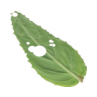

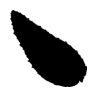

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["figure.figsize"] = (32, 1)


def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))


images, masks = iter(dataset[1])

show(images)
show(masks)

In [ ]:
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn

model = smp.UnetPlusPlus(encoder_name="efficientnet-b0", classes = 1, activation = "sigmoid")
criterion =  smp.losses.FocalLoss('binary')
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
%%time
masks_in_progress = []
for epoch in range(10):
  train(model, criterion, optimizer, epoch, masks_in_progress)

torch.save(model.state_dict(), "/content/drive/MyDrive/нейросеть/leaves/SMP_dataset2_UnetPlusPlus_FocalLoss.pth")

Epoch 0 Train loss 0.10 Val loss 0.13
Epoch 1 Train loss 0.10 Val loss 0.13
Epoch 2 Train loss 0.10 Val loss 0.13
Epoch 3 Train loss 0.10 Val loss 0.13
Epoch 4 Train loss 0.10 Val loss 0.13
Epoch 5 Train loss 0.09 Val loss 0.13
Epoch 6 Train loss 0.09 Val loss 0.13
Epoch 7 Train loss 0.09 Val loss 0.13
Epoch 8 Train loss 0.09 Val loss 0.13
Epoch 9 Train loss 0.09 Val loss 0.13
CPU times: user 1h 15min 13s, sys: 56.3 s, total: 1h 16min 9s
Wall time: 1h 16min 40s


In [ ]:
import segmentation_models_pytorch as smp
import torch
model = smp.UnetPlusPlus(encoder_name="efficientnet-b0", classes = 1, activation = "sigmoid")
model.load_state_dict(torch.load("/content/drive/MyDrive/нейросеть/leaves/SMP_dataset2_UnetPlusPlus_FocalLoss.pth"))
model.to(device)

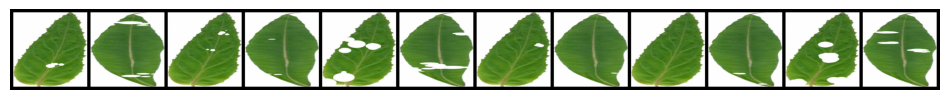

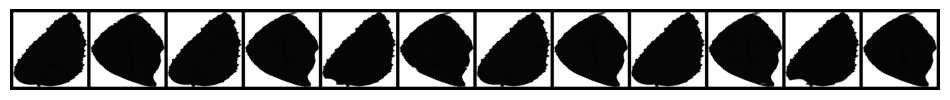

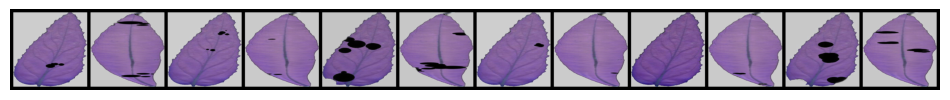

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show(batch, cols=16, max_size=256):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols, normalize=True, scale_each=True, max_size=max_size)
    plt.figure(figsize=(cols, cols))
    plt.axis("off")
    plt.imshow(np.transpose(img_grid.cpu().numpy(), (1, 2, 0)))


def show_valset_pred(model, cols=16):
    images, pred_masks = [], []
    for batch in dataset_test:
        with torch.no_grad():
            img, mask = batch
            images.append(img)
            output = model(img.unsqueeze(0).to(device)).squeeze()
            pred_masks.append(output.cpu())
    show(torch.stack(images)[:cols, ...])
    show(torch.stack(pred_masks).unsqueeze(1)[:cols, ...])
    show(torch.stack(pred_masks).unsqueeze(1)[:cols, ...] - torch.stack(images)[:cols, ...])


show_valset_pred(model)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


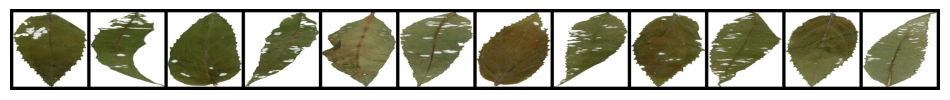

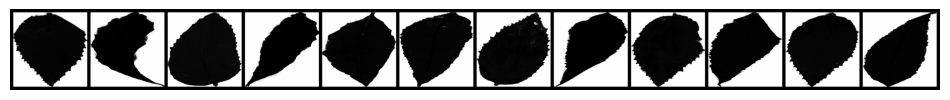

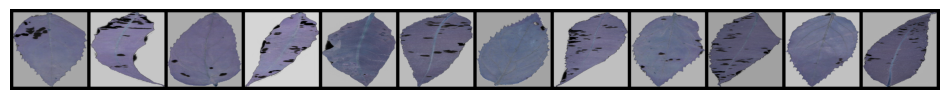

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import cv2
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def load_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return transforms.Compose([ transforms.ToTensor(), transforms.Resize((224, 224))])(img)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder1):
        self.folder1 = folder1
        self.filenames = [f for f in os.listdir(folder1)]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img1_path = os.path.join(self.folder1, filename)
        img1 = load_image(img1_path)
        return img1

true_test = CustomDataset('/content/drive/MyDrive/нейросеть/leaves/true_test')


def show_valset_pred(model, cols=16):
    images, pred_masks = [], []
    for batch in true_test:
        with torch.no_grad():
            img = batch
            images.append(img.unsqueeze(0))
            output = model(img.unsqueeze(0).to(device))
            pred_masks.append(output.cpu())
    show(torch.stack(images).squeeze()[:cols, ...])
    show(torch.stack(pred_masks).squeeze(1)[:cols, ...])
    show(torch.stack(pred_masks).squeeze(1)[:cols, ...] - torch.stack(images).squeeze()[:cols, ...])

show_valset_pred(model)

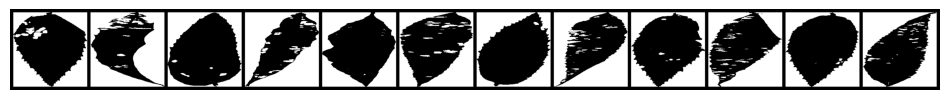

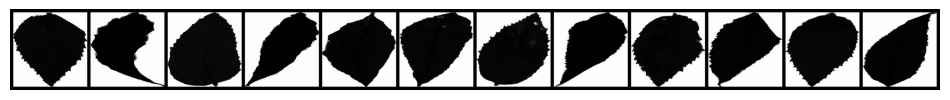

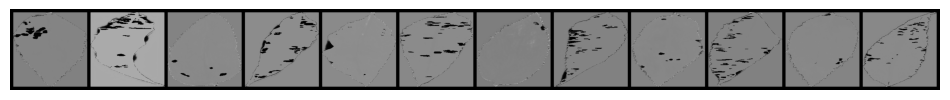

In [ ]:
def show_valset_pred(model, cols=16):
    images, pred_masks = [], []
    for batch in true_test:
        with torch.no_grad():
            img = batch
            images.append(binarize_image(img, 0.6))
            output = model(img.unsqueeze(0).to(device))
            pred_masks.append(output.cpu())
    show(torch.stack(images)[:cols, ...])
    show(torch.stack(pred_masks).squeeze(1)[:cols, ...])
    show(torch.stack(pred_masks).squeeze(1)[:cols, ...] - torch.stack(images)[:cols, ...])

show_valset_pred(model)

In [ ]:
import os
from PIL import Image

folder = '/content/drive/MyDrive/нейросеть/leaves/true_test'
image_sizes = []

for filename in os.listdir(folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        filepath = os.path.join(folder, filename)
        with Image.open(filepath) as img:
            image_sizes.append(img.size)

image_sizes = [(y, x) for x, y in image_sizes]

import torch

def resize_images(images, sizes):
    resized_images = []
    for img, size in zip(images, sizes):
        resized_img = torch.nn.functional.interpolate(img, size=size, mode='bilinear', align_corners=False)
        resized_images.append(resized_img)
    return resized_images

images, pred_masks = [], []
for batch in true_test:
    with torch.no_grad():
        img = batch
        images.append(binarize_image(img, 0.8).unsqueeze(0))
        output = model(img.unsqueeze(0).to(device))
        pred_masks.append(output.cpu())

resized_images = resize_images(torch.stack(images), image_sizes)
resized_masks = resize_images(torch.stack(pred_masks), image_sizes)

def subtract_tensor_lists(list1, list2):
    result = []
    for t1, t2 in zip(list1, list2):
        subtracted_tensor = binarize_image(t1 - t2, 0.8)
        result.append(subtracted_tensor.squeeze())
    return result

# Выполняем операцию вычитания одного списка из другого
subtracted_list = subtract_tensor_lists(resized_masks, resized_images)

In [ ]:
def resize_images(images, sizes):
    resized_images = []
    for img, size in zip(images, sizes):
        resized_img = torch.nn.functional.interpolate(img, size=size, mode='bilinear', align_corners=False)
        resized_images.append(resized_img)
    return resized_images

images, pred_masks = [], []
for batch in true_test:
    with torch.no_grad():
        img = batch
        images.append(binarize_image(img, 0.6).unsqueeze(0))
        output = model(img.unsqueeze(0).to(device))
        pred_masks.append(output.cpu())

resized_images = resize_images(images, image_sizes)
resized_masks = resize_images(pred_masks, image_sizes)

def subtract_tensor_lists(list1, list2):
    result = []
    for t1, t2 in zip(list1, list2):
        subtracted_tensor = binarize_image(t1 - t2, 0.05)
        result.append(subtracted_tensor.squeeze())
    return result

# Выполняем операцию вычитания одного списка из другого
subtracted_list = subtract_tensor_lists(resized_masks, resized_images)

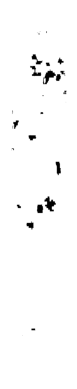

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(subtracted_list[5], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

def count_black_pixels(image_tensor):
    # Преобразуем тензор в массив NumPy
    image_array = np.array(image_tensor)

    # Подсчитываем количество черных пикселей
    num_black_pixels = np.sum(image_array == 0)

    return num_black_pixels

square  = []
for tensor in subtracted_list:
  square.append(count_black_pixels(tensor))

print(square)

NameError: ignored